# GAN (Generative Adversarial Network)

GAN introduced by **Ian Goodfellow** in 2014, attacks the problem of unsupervised learning by training two deep networks, called Generator and Discriminator, that compete and cooperate with each other. In the course of training, both networks eventually learn how to perform their tasks.

GAN is almost always explained like the case of a counterfeiter (Generative) and the police (Discriminator). Initially, the counterfeiter will show the police a fake money. The police says it is fake. The police gives feedback to the counterfeiter why the money is fake. The counterfeiter attempts to make a new fake money based on the feedback it received. The police says the money is still fake and offers a new set of feedback. The counterfeiter attempts to make a new fake money based on the latest feedback. The cycle continues indefinitely until the police is fooled by the fake money because it looks real.

## dataset used : MNIST


In [2]:
from numpy import expand_dims,zeros,ones,vstack
from numpy.random import randn,randint
from keras.datasets.mnist import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense,Reshape,Flatten,Conv2D,Conv2DTranspose,LeakyReLU,Dropout
from matplotlib import pyplot
%matplotlib inline

In [5]:
# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    #leakyrelu with alpha 0.2 is considered one of the best way to train GANs 
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    # compile model
    opt = Adam(lr=0.0002)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model
 
# define the standalone generator model
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 7x7 image
    #128 so that we can plot many 7*7 images as the o/p
	n_nodes = 128 * 7 * 7
    #latent dimension that is 100 here is used to create image that is 100 input converted t image of given size
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
    #converting flatten points into 2D points
	model.add(Reshape((7, 7, 128)))
	# upsample to 14x14
    #conv2DTranspose is used to upscale the input can also use Upscaling2D and then con2D but this is modern approch
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 28x28
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
	return model
 
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(g_model)
	# add the discriminator
	model.add(d_model)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model
 
# load and prepare mnist training images
def load_real_samples():
	# load mnist dataset
	(trainX, _), (_, _) = load_data()
	# expand to 3d, e.g. add channels dimension
	X = expand_dims(trainX, axis=-1)
	# convert from unsigned ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [0,1]
	X = X / 255.0
	return X
 
# select real samples
def generate_real_samples(dataset, n_samples):
	# choose random instances
	ix = randint(0, dataset.shape[0], n_samples)
	# retrieve selected images
	X = dataset[ix]
	# generate 'real' class labels (1)
	y = ones((n_samples, 1))
	return X, y
 
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input
 
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = g_model.predict(x_input)
	# create 'fake' class labels (0)
	y = zeros((n_samples, 1))
	return X, y
 
# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, epoch, n=10):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	# save plot to file
	filename = 'generated_plot_e%03d.png' % (epoch+1)
	pyplot.savefig(filename)
	pyplot.close()
 # not important function can be skipped just to know how model is training
    #evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
	# prepare real samples
	X_real, y_real = generate_real_samples(dataset, n_samples)
	# evaluate discriminator on real examples
	_, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
	# prepare fake examples
	x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
	# evaluate discriminator on fake examples
	_, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
	# summarize discriminator performance
	print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
	# save plot
	save_plot(x_fake, epoch)
	# save the generator model tile file
	filename = 'generator_model_%03d.h5' % (epoch + 1)
	g_model.save(filename)
 
# train the generator and discriminator

def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=20, n_batch=256):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# create training set for the discriminator
			X, y = vstack((X_real, X_fake)), vstack((y_real, y_fake))
			# update discriminator model weights
			d_loss, _ = d_model.train_on_batch(X, y)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d=%.3f, g=%.3f' % (i+1, j+1, bat_per_epo, d_loss, g_loss))
		# evaluate the model performance, sometimes
		if (i+1) % 10 == 0:
			summarize_performance(i, g_model, d_model, dataset, latent_dim)
 
# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

>1, 1/234, d=0.700, g=0.699


C:\Users\hseth\Anaconda3\envs\tf_gpu\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


>1, 2/234, d=0.696, g=0.712
>1, 3/234, d=0.683, g=0.729
>1, 4/234, d=0.677, g=0.743
>1, 5/234, d=0.670, g=0.759
>1, 6/234, d=0.667, g=0.772
>1, 7/234, d=0.660, g=0.779
>1, 8/234, d=0.656, g=0.790
>1, 9/234, d=0.651, g=0.797
>1, 10/234, d=0.652, g=0.798
>1, 11/234, d=0.649, g=0.791
>1, 12/234, d=0.648, g=0.785
>1, 13/234, d=0.650, g=0.774
>1, 14/234, d=0.655, g=0.757
>1, 15/234, d=0.655, g=0.743
>1, 16/234, d=0.654, g=0.729
>1, 17/234, d=0.654, g=0.717
>1, 18/234, d=0.653, g=0.709
>1, 19/234, d=0.650, g=0.701
>1, 20/234, d=0.648, g=0.697
>1, 21/234, d=0.641, g=0.694
>1, 22/234, d=0.640, g=0.692
>1, 23/234, d=0.630, g=0.691
>1, 24/234, d=0.624, g=0.692
>1, 25/234, d=0.616, g=0.692
>1, 26/234, d=0.612, g=0.692
>1, 27/234, d=0.600, g=0.693
>1, 28/234, d=0.594, g=0.693
>1, 29/234, d=0.583, g=0.694
>1, 30/234, d=0.575, g=0.695
>1, 31/234, d=0.567, g=0.696
>1, 32/234, d=0.554, g=0.697
>1, 33/234, d=0.551, g=0.698
>1, 34/234, d=0.533, g=0.699
>1, 35/234, d=0.527, g=0.700
>1, 36/234, d=0.520, g

>2, 47/234, d=0.642, g=0.751
>2, 48/234, d=0.661, g=0.787
>2, 49/234, d=0.646, g=0.779
>2, 50/234, d=0.660, g=0.760
>2, 51/234, d=0.670, g=0.750
>2, 52/234, d=0.638, g=0.758
>2, 53/234, d=0.672, g=0.740
>2, 54/234, d=0.669, g=0.745
>2, 55/234, d=0.696, g=0.741
>2, 56/234, d=0.693, g=0.732
>2, 57/234, d=0.686, g=0.717
>2, 58/234, d=0.662, g=0.718
>2, 59/234, d=0.657, g=0.701
>2, 60/234, d=0.692, g=0.717
>2, 61/234, d=0.656, g=0.706
>2, 62/234, d=0.698, g=0.724
>2, 63/234, d=0.700, g=0.719
>2, 64/234, d=0.682, g=0.693
>2, 65/234, d=0.674, g=0.715
>2, 66/234, d=0.673, g=0.735
>2, 67/234, d=0.667, g=0.746
>2, 68/234, d=0.650, g=0.756
>2, 69/234, d=0.675, g=0.747
>2, 70/234, d=0.645, g=0.728
>2, 71/234, d=0.672, g=0.753
>2, 72/234, d=0.666, g=0.741
>2, 73/234, d=0.653, g=0.777
>2, 74/234, d=0.669, g=0.762
>2, 75/234, d=0.660, g=0.752
>2, 76/234, d=0.641, g=0.757
>2, 77/234, d=0.628, g=0.770
>2, 78/234, d=0.623, g=0.762
>2, 79/234, d=0.651, g=0.783
>2, 80/234, d=0.654, g=0.774
>2, 81/234, d=

>3, 93/234, d=0.676, g=0.762
>3, 94/234, d=0.673, g=0.739
>3, 95/234, d=0.669, g=0.734
>3, 96/234, d=0.668, g=0.737
>3, 97/234, d=0.673, g=0.750
>3, 98/234, d=0.679, g=0.730
>3, 99/234, d=0.668, g=0.721
>3, 100/234, d=0.672, g=0.762
>3, 101/234, d=0.669, g=0.737
>3, 102/234, d=0.677, g=0.750
>3, 103/234, d=0.671, g=0.734
>3, 104/234, d=0.676, g=0.741
>3, 105/234, d=0.670, g=0.743
>3, 106/234, d=0.675, g=0.750
>3, 107/234, d=0.671, g=0.749
>3, 108/234, d=0.689, g=0.754
>3, 109/234, d=0.671, g=0.751
>3, 110/234, d=0.691, g=0.780
>3, 111/234, d=0.659, g=0.757
>3, 112/234, d=0.683, g=0.735
>3, 113/234, d=0.668, g=0.764
>3, 114/234, d=0.669, g=0.752
>3, 115/234, d=0.681, g=0.749
>3, 116/234, d=0.698, g=0.738
>3, 117/234, d=0.688, g=0.748
>3, 118/234, d=0.679, g=0.752
>3, 119/234, d=0.695, g=0.729
>3, 120/234, d=0.674, g=0.730
>3, 121/234, d=0.695, g=0.722
>3, 122/234, d=0.691, g=0.738
>3, 123/234, d=0.688, g=0.741
>3, 124/234, d=0.677, g=0.730
>3, 125/234, d=0.691, g=0.725
>3, 126/234, d=0.

>4, 136/234, d=0.695, g=0.715
>4, 137/234, d=0.701, g=0.723
>4, 138/234, d=0.696, g=0.699
>4, 139/234, d=0.700, g=0.706
>4, 140/234, d=0.697, g=0.712
>4, 141/234, d=0.707, g=0.696
>4, 142/234, d=0.697, g=0.718
>4, 143/234, d=0.713, g=0.713
>4, 144/234, d=0.699, g=0.717
>4, 145/234, d=0.698, g=0.704
>4, 146/234, d=0.697, g=0.710
>4, 147/234, d=0.703, g=0.708
>4, 148/234, d=0.710, g=0.710
>4, 149/234, d=0.709, g=0.710
>4, 150/234, d=0.710, g=0.703
>4, 151/234, d=0.701, g=0.707
>4, 152/234, d=0.702, g=0.706
>4, 153/234, d=0.716, g=0.710
>4, 154/234, d=0.716, g=0.710
>4, 155/234, d=0.713, g=0.717
>4, 156/234, d=0.699, g=0.707
>4, 157/234, d=0.693, g=0.708
>4, 158/234, d=0.699, g=0.710
>4, 159/234, d=0.713, g=0.702
>4, 160/234, d=0.721, g=0.702
>4, 161/234, d=0.702, g=0.700
>4, 162/234, d=0.714, g=0.708
>4, 163/234, d=0.709, g=0.706
>4, 164/234, d=0.714, g=0.714
>4, 165/234, d=0.698, g=0.724
>4, 166/234, d=0.702, g=0.714
>4, 167/234, d=0.712, g=0.710
>4, 168/234, d=0.703, g=0.704
>4, 169/23

>5, 180/234, d=0.692, g=0.725
>5, 181/234, d=0.680, g=0.731
>5, 182/234, d=0.691, g=0.705
>5, 183/234, d=0.693, g=0.706
>5, 184/234, d=0.697, g=0.708
>5, 185/234, d=0.694, g=0.702
>5, 186/234, d=0.700, g=0.686
>5, 187/234, d=0.694, g=0.702
>5, 188/234, d=0.700, g=0.693
>5, 189/234, d=0.683, g=0.692
>5, 190/234, d=0.698, g=0.693
>5, 191/234, d=0.698, g=0.694
>5, 192/234, d=0.686, g=0.696
>5, 193/234, d=0.692, g=0.688
>5, 194/234, d=0.694, g=0.691
>5, 195/234, d=0.693, g=0.697
>5, 196/234, d=0.696, g=0.707
>5, 197/234, d=0.697, g=0.698
>5, 198/234, d=0.690, g=0.720
>5, 199/234, d=0.697, g=0.715
>5, 200/234, d=0.696, g=0.705
>5, 201/234, d=0.690, g=0.709
>5, 202/234, d=0.698, g=0.706
>5, 203/234, d=0.695, g=0.696
>5, 204/234, d=0.699, g=0.691
>5, 205/234, d=0.699, g=0.680
>5, 206/234, d=0.689, g=0.689
>5, 207/234, d=0.684, g=0.698
>5, 208/234, d=0.690, g=0.692
>5, 209/234, d=0.689, g=0.694
>5, 210/234, d=0.694, g=0.704
>5, 211/234, d=0.700, g=0.706
>5, 212/234, d=0.697, g=0.707
>5, 213/23

>6, 224/234, d=0.673, g=0.719
>6, 225/234, d=0.675, g=0.724
>6, 226/234, d=0.676, g=0.717
>6, 227/234, d=0.680, g=0.719
>6, 228/234, d=0.675, g=0.716
>6, 229/234, d=0.674, g=0.713
>6, 230/234, d=0.684, g=0.712
>6, 231/234, d=0.669, g=0.703
>6, 232/234, d=0.682, g=0.705
>6, 233/234, d=0.675, g=0.691
>6, 234/234, d=0.677, g=0.685
>7, 1/234, d=0.682, g=0.686
>7, 2/234, d=0.680, g=0.686
>7, 3/234, d=0.686, g=0.694
>7, 4/234, d=0.685, g=0.699
>7, 5/234, d=0.688, g=0.709
>7, 6/234, d=0.689, g=0.713
>7, 7/234, d=0.697, g=0.714
>7, 8/234, d=0.695, g=0.719
>7, 9/234, d=0.691, g=0.714
>7, 10/234, d=0.689, g=0.703
>7, 11/234, d=0.682, g=0.693
>7, 12/234, d=0.682, g=0.684
>7, 13/234, d=0.685, g=0.673
>7, 14/234, d=0.686, g=0.668
>7, 15/234, d=0.688, g=0.654
>7, 16/234, d=0.708, g=0.669
>7, 17/234, d=0.704, g=0.681
>7, 18/234, d=0.694, g=0.696
>7, 19/234, d=0.709, g=0.710
>7, 20/234, d=0.698, g=0.720
>7, 21/234, d=0.699, g=0.742
>7, 22/234, d=0.690, g=0.739
>7, 23/234, d=0.698, g=0.733
>7, 24/234, 

>8, 36/234, d=0.664, g=0.685
>8, 37/234, d=0.651, g=0.677
>8, 38/234, d=0.646, g=0.677
>8, 39/234, d=0.645, g=0.678
>8, 40/234, d=0.646, g=0.669
>8, 41/234, d=0.659, g=0.666
>8, 42/234, d=0.684, g=0.683
>8, 43/234, d=0.702, g=0.783
>8, 44/234, d=0.683, g=0.897
>8, 45/234, d=0.659, g=1.019
>8, 46/234, d=0.656, g=1.042
>8, 47/234, d=0.664, g=0.982
>8, 48/234, d=0.675, g=0.863
>8, 49/234, d=0.683, g=0.783
>8, 50/234, d=0.685, g=0.707
>8, 51/234, d=0.694, g=0.671
>8, 52/234, d=0.695, g=0.639
>8, 53/234, d=0.683, g=0.627
>8, 54/234, d=0.660, g=0.621
>8, 55/234, d=0.648, g=0.618
>8, 56/234, d=0.657, g=0.614
>8, 57/234, d=0.659, g=0.592
>8, 58/234, d=0.682, g=0.559
>8, 59/234, d=0.739, g=0.549
>8, 60/234, d=0.757, g=0.596
>8, 61/234, d=0.773, g=0.701
>8, 62/234, d=0.736, g=0.863
>8, 63/234, d=0.702, g=0.951
>8, 64/234, d=0.698, g=0.986
>8, 65/234, d=0.707, g=0.928
>8, 66/234, d=0.713, g=0.847
>8, 67/234, d=0.722, g=0.778
>8, 68/234, d=0.720, g=0.721
>8, 69/234, d=0.729, g=0.674
>8, 70/234, d=

>10, 121/234, d=0.687, g=0.718
>10, 122/234, d=0.695, g=0.721
>10, 123/234, d=0.692, g=0.716
>10, 124/234, d=0.688, g=0.705
>10, 125/234, d=0.700, g=0.700
>10, 126/234, d=0.690, g=0.700
>10, 127/234, d=0.696, g=0.703
>10, 128/234, d=0.688, g=0.697
>10, 129/234, d=0.683, g=0.705
>10, 130/234, d=0.696, g=0.704
>10, 131/234, d=0.680, g=0.703
>10, 132/234, d=0.688, g=0.709
>10, 133/234, d=0.682, g=0.694
>10, 134/234, d=0.676, g=0.705
>10, 135/234, d=0.684, g=0.712
>10, 136/234, d=0.671, g=0.729
>10, 137/234, d=0.680, g=0.726
>10, 138/234, d=0.683, g=0.736
>10, 139/234, d=0.676, g=0.723
>10, 140/234, d=0.676, g=0.722
>10, 141/234, d=0.678, g=0.723
>10, 142/234, d=0.685, g=0.712
>10, 143/234, d=0.680, g=0.707
>10, 144/234, d=0.674, g=0.711
>10, 145/234, d=0.682, g=0.704
>10, 146/234, d=0.670, g=0.698
>10, 147/234, d=0.671, g=0.713
>10, 148/234, d=0.680, g=0.715
>10, 149/234, d=0.681, g=0.701
>10, 150/234, d=0.679, g=0.702
>10, 151/234, d=0.679, g=0.710
>10, 152/234, d=0.675, g=0.718
>10, 153

>11, 154/234, d=0.683, g=0.733
>11, 155/234, d=0.677, g=0.749
>11, 156/234, d=0.680, g=0.746
>11, 157/234, d=0.665, g=0.738
>11, 158/234, d=0.653, g=0.743
>11, 159/234, d=0.658, g=0.737
>11, 160/234, d=0.666, g=0.728
>11, 161/234, d=0.673, g=0.729
>11, 162/234, d=0.664, g=0.715
>11, 163/234, d=0.671, g=0.719
>11, 164/234, d=0.671, g=0.718
>11, 165/234, d=0.662, g=0.719
>11, 166/234, d=0.676, g=0.734
>11, 167/234, d=0.669, g=0.732
>11, 168/234, d=0.672, g=0.732
>11, 169/234, d=0.680, g=0.731
>11, 170/234, d=0.663, g=0.718
>11, 171/234, d=0.668, g=0.722
>11, 172/234, d=0.679, g=0.708
>11, 173/234, d=0.679, g=0.700
>11, 174/234, d=0.692, g=0.706
>11, 175/234, d=0.678, g=0.697
>11, 176/234, d=0.677, g=0.693
>11, 177/234, d=0.681, g=0.704
>11, 178/234, d=0.680, g=0.706
>11, 179/234, d=0.696, g=0.712
>11, 180/234, d=0.689, g=0.715
>11, 181/234, d=0.692, g=0.709
>11, 182/234, d=0.695, g=0.727
>11, 183/234, d=0.697, g=0.734
>11, 184/234, d=0.686, g=0.736
>11, 185/234, d=0.693, g=0.735
>11, 186

>12, 188/234, d=0.671, g=0.729
>12, 189/234, d=0.671, g=0.728
>12, 190/234, d=0.672, g=0.717
>12, 191/234, d=0.673, g=0.720
>12, 192/234, d=0.673, g=0.728
>12, 193/234, d=0.676, g=0.731
>12, 194/234, d=0.677, g=0.749
>12, 195/234, d=0.670, g=0.749
>12, 196/234, d=0.663, g=0.734
>12, 197/234, d=0.667, g=0.729
>12, 198/234, d=0.672, g=0.744
>12, 199/234, d=0.670, g=0.718
>12, 200/234, d=0.664, g=0.708
>12, 201/234, d=0.667, g=0.710
>12, 202/234, d=0.673, g=0.705
>12, 203/234, d=0.667, g=0.724
>12, 204/234, d=0.669, g=0.734
>12, 205/234, d=0.676, g=0.749
>12, 206/234, d=0.684, g=0.739
>12, 207/234, d=0.681, g=0.731
>12, 208/234, d=0.680, g=0.704
>12, 209/234, d=0.678, g=0.712
>12, 210/234, d=0.680, g=0.717
>12, 211/234, d=0.687, g=0.718
>12, 212/234, d=0.678, g=0.718
>12, 213/234, d=0.694, g=0.722
>12, 214/234, d=0.697, g=0.719
>12, 215/234, d=0.689, g=0.700
>12, 216/234, d=0.694, g=0.692
>12, 217/234, d=0.696, g=0.701
>12, 218/234, d=0.700, g=0.712
>12, 219/234, d=0.696, g=0.715
>12, 220

>13, 222/234, d=0.692, g=0.706
>13, 223/234, d=0.691, g=0.695
>13, 224/234, d=0.687, g=0.687
>13, 225/234, d=0.688, g=0.696
>13, 226/234, d=0.685, g=0.713
>13, 227/234, d=0.688, g=0.714
>13, 228/234, d=0.689, g=0.719
>13, 229/234, d=0.681, g=0.717
>13, 230/234, d=0.684, g=0.725
>13, 231/234, d=0.677, g=0.700
>13, 232/234, d=0.678, g=0.721
>13, 233/234, d=0.679, g=0.720
>13, 234/234, d=0.684, g=0.727
>14, 1/234, d=0.672, g=0.720
>14, 2/234, d=0.676, g=0.706
>14, 3/234, d=0.679, g=0.708
>14, 4/234, d=0.680, g=0.720
>14, 5/234, d=0.663, g=0.736
>14, 6/234, d=0.680, g=0.736
>14, 7/234, d=0.679, g=0.720
>14, 8/234, d=0.674, g=0.729
>14, 9/234, d=0.679, g=0.717
>14, 10/234, d=0.693, g=0.709
>14, 11/234, d=0.696, g=0.701
>14, 12/234, d=0.686, g=0.712
>14, 13/234, d=0.690, g=0.707
>14, 14/234, d=0.689, g=0.710
>14, 15/234, d=0.693, g=0.707
>14, 16/234, d=0.693, g=0.705
>14, 17/234, d=0.685, g=0.688
>14, 18/234, d=0.685, g=0.707
>14, 19/234, d=0.690, g=0.712
>14, 20/234, d=0.695, g=0.728
>14, 2

>15, 23/234, d=0.688, g=0.737
>15, 24/234, d=0.691, g=0.746
>15, 25/234, d=0.693, g=0.718
>15, 26/234, d=0.676, g=0.702
>15, 27/234, d=0.681, g=0.674
>15, 28/234, d=0.694, g=0.672
>15, 29/234, d=0.692, g=0.697
>15, 30/234, d=0.691, g=0.736
>15, 31/234, d=0.684, g=0.760
>15, 32/234, d=0.675, g=0.749
>15, 33/234, d=0.672, g=0.742
>15, 34/234, d=0.677, g=0.712
>15, 35/234, d=0.683, g=0.696
>15, 36/234, d=0.664, g=0.689
>15, 37/234, d=0.668, g=0.710
>15, 38/234, d=0.678, g=0.723
>15, 39/234, d=0.671, g=0.730
>15, 40/234, d=0.674, g=0.743
>15, 41/234, d=0.671, g=0.734
>15, 42/234, d=0.681, g=0.720
>15, 43/234, d=0.678, g=0.713
>15, 44/234, d=0.680, g=0.703
>15, 45/234, d=0.690, g=0.707
>15, 46/234, d=0.688, g=0.712
>15, 47/234, d=0.690, g=0.728
>15, 48/234, d=0.699, g=0.703
>15, 49/234, d=0.701, g=0.693
>15, 50/234, d=0.701, g=0.676
>15, 51/234, d=0.702, g=0.678
>15, 52/234, d=0.702, g=0.698
>15, 53/234, d=0.697, g=0.709
>15, 54/234, d=0.696, g=0.710
>15, 55/234, d=0.695, g=0.704
>15, 56/23

>16, 58/234, d=0.679, g=0.679
>16, 59/234, d=0.686, g=0.678
>16, 60/234, d=0.689, g=0.690
>16, 61/234, d=0.685, g=0.728
>16, 62/234, d=0.683, g=0.748
>16, 63/234, d=0.687, g=0.737
>16, 64/234, d=0.689, g=0.699
>16, 65/234, d=0.678, g=0.685
>16, 66/234, d=0.692, g=0.678
>16, 67/234, d=0.679, g=0.694
>16, 68/234, d=0.674, g=0.716
>16, 69/234, d=0.686, g=0.741
>16, 70/234, d=0.684, g=0.748
>16, 71/234, d=0.680, g=0.738
>16, 72/234, d=0.686, g=0.725
>16, 73/234, d=0.679, g=0.700
>16, 74/234, d=0.674, g=0.701
>16, 75/234, d=0.692, g=0.693
>16, 76/234, d=0.677, g=0.706
>16, 77/234, d=0.678, g=0.713
>16, 78/234, d=0.689, g=0.739
>16, 79/234, d=0.683, g=0.724
>16, 80/234, d=0.688, g=0.713
>16, 81/234, d=0.691, g=0.686
>16, 82/234, d=0.676, g=0.693
>16, 83/234, d=0.689, g=0.717
>16, 84/234, d=0.693, g=0.730
>16, 85/234, d=0.688, g=0.731
>16, 86/234, d=0.693, g=0.715
>16, 87/234, d=0.683, g=0.680
>16, 88/234, d=0.690, g=0.668
>16, 89/234, d=0.690, g=0.684
>16, 90/234, d=0.688, g=0.712
>16, 91/23

>17, 93/234, d=0.680, g=0.722
>17, 94/234, d=0.681, g=0.724
>17, 95/234, d=0.676, g=0.721
>17, 96/234, d=0.688, g=0.709
>17, 97/234, d=0.686, g=0.679
>17, 98/234, d=0.691, g=0.693
>17, 99/234, d=0.693, g=0.693
>17, 100/234, d=0.685, g=0.741
>17, 101/234, d=0.682, g=0.749
>17, 102/234, d=0.685, g=0.726
>17, 103/234, d=0.690, g=0.709
>17, 104/234, d=0.686, g=0.698
>17, 105/234, d=0.674, g=0.690
>17, 106/234, d=0.678, g=0.697
>17, 107/234, d=0.687, g=0.707
>17, 108/234, d=0.684, g=0.728
>17, 109/234, d=0.692, g=0.735
>17, 110/234, d=0.680, g=0.719
>17, 111/234, d=0.686, g=0.700
>17, 112/234, d=0.682, g=0.686
>17, 113/234, d=0.682, g=0.704
>17, 114/234, d=0.683, g=0.730
>17, 115/234, d=0.685, g=0.734
>17, 116/234, d=0.688, g=0.721
>17, 117/234, d=0.681, g=0.714
>17, 118/234, d=0.693, g=0.702
>17, 119/234, d=0.681, g=0.689
>17, 120/234, d=0.692, g=0.688
>17, 121/234, d=0.691, g=0.719
>17, 122/234, d=0.679, g=0.741
>17, 123/234, d=0.689, g=0.711
>17, 124/234, d=0.689, g=0.708
>17, 125/234, d

>18, 128/234, d=0.696, g=0.704
>18, 129/234, d=0.679, g=0.694
>18, 130/234, d=0.694, g=0.692
>18, 131/234, d=0.693, g=0.716
>18, 132/234, d=0.679, g=0.729
>18, 133/234, d=0.680, g=0.729
>18, 134/234, d=0.679, g=0.693
>18, 135/234, d=0.695, g=0.684
>18, 136/234, d=0.685, g=0.691
>18, 137/234, d=0.681, g=0.715
>18, 138/234, d=0.690, g=0.714
>18, 139/234, d=0.670, g=0.718
>18, 140/234, d=0.685, g=0.713
>18, 141/234, d=0.676, g=0.702
>18, 142/234, d=0.680, g=0.715
>18, 143/234, d=0.678, g=0.720
>18, 144/234, d=0.694, g=0.692
>18, 145/234, d=0.686, g=0.698
>18, 146/234, d=0.684, g=0.713
>18, 147/234, d=0.683, g=0.711
>18, 148/234, d=0.687, g=0.716
>18, 149/234, d=0.682, g=0.713
>18, 150/234, d=0.687, g=0.705
>18, 151/234, d=0.686, g=0.687
>18, 152/234, d=0.690, g=0.695
>18, 153/234, d=0.683, g=0.697
>18, 154/234, d=0.686, g=0.733
>18, 155/234, d=0.683, g=0.739
>18, 156/234, d=0.693, g=0.721
>18, 157/234, d=0.683, g=0.675
>18, 158/234, d=0.679, g=0.684
>18, 159/234, d=0.692, g=0.698
>18, 160

>19, 162/234, d=0.687, g=0.619
>19, 163/234, d=0.699, g=0.693
>19, 164/234, d=0.680, g=0.782
>19, 165/234, d=0.693, g=0.805
>19, 166/234, d=0.687, g=0.744
>19, 167/234, d=0.677, g=0.691
>19, 168/234, d=0.695, g=0.654
>19, 169/234, d=0.689, g=0.651
>19, 170/234, d=0.675, g=0.675
>19, 171/234, d=0.692, g=0.761
>19, 172/234, d=0.677, g=0.783
>19, 173/234, d=0.679, g=0.774
>19, 174/234, d=0.691, g=0.717
>19, 175/234, d=0.695, g=0.676
>19, 176/234, d=0.679, g=0.672
>19, 177/234, d=0.692, g=0.677
>19, 178/234, d=0.690, g=0.724
>19, 179/234, d=0.685, g=0.760
>19, 180/234, d=0.684, g=0.774
>19, 181/234, d=0.685, g=0.738
>19, 182/234, d=0.692, g=0.695
>19, 183/234, d=0.690, g=0.664
>19, 184/234, d=0.686, g=0.665
>19, 185/234, d=0.686, g=0.699
>19, 186/234, d=0.681, g=0.729
>19, 187/234, d=0.678, g=0.730
>19, 188/234, d=0.689, g=0.724
>19, 189/234, d=0.691, g=0.707
>19, 190/234, d=0.679, g=0.688
>19, 191/234, d=0.684, g=0.678
>19, 192/234, d=0.689, g=0.675
>19, 193/234, d=0.690, g=0.709
>19, 194

>20, 197/234, d=0.685, g=0.730
>20, 198/234, d=0.675, g=0.735
>20, 199/234, d=0.692, g=0.717
>20, 200/234, d=0.684, g=0.693
>20, 201/234, d=0.691, g=0.698
>20, 202/234, d=0.687, g=0.703
>20, 203/234, d=0.688, g=0.688
>20, 204/234, d=0.695, g=0.691
>20, 205/234, d=0.674, g=0.702
>20, 206/234, d=0.690, g=0.719
>20, 207/234, d=0.681, g=0.728
>20, 208/234, d=0.691, g=0.717
>20, 209/234, d=0.688, g=0.726
>20, 210/234, d=0.687, g=0.704
>20, 211/234, d=0.692, g=0.699
>20, 212/234, d=0.689, g=0.714
>20, 213/234, d=0.694, g=0.709
>20, 214/234, d=0.691, g=0.699
>20, 215/234, d=0.681, g=0.685
>20, 216/234, d=0.686, g=0.679
>20, 217/234, d=0.687, g=0.695
>20, 218/234, d=0.685, g=0.754
>20, 219/234, d=0.689, g=0.798
>20, 220/234, d=0.692, g=0.771
>20, 221/234, d=0.688, g=0.726
>20, 222/234, d=0.690, g=0.672
>20, 223/234, d=0.681, g=0.643
>20, 224/234, d=0.688, g=0.647
>20, 225/234, d=0.691, g=0.699
>20, 226/234, d=0.694, g=0.757
>20, 227/234, d=0.690, g=0.780
>20, 228/234, d=0.689, g=0.751
>20, 229

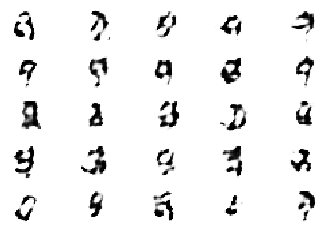

In [8]:
# using above created model as a testing phase 
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('generator_model_010.h5')
# generate images
latent_points = generate_latent_points(100, 25)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 5)